In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from cvaei.models.cvae_inference import CVAE
from cvaei.helper import DataNormalizer
from cvaei.visualize import scatter_plot_ma2
from cvaei.examples.MA2 import MovingAverage2



In [11]:
ma2 = MovingAverage2()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = ma2.prepare_data(10000)
x = ma2.observed_data()


In [12]:
x

tensor([[0.0000, 0.6508, 0.5545, 0.5806, 0.2961, 0.5077, 0.2810, 0.2662, 0.3526,
         0.3935, 0.7074, 0.5465, 0.3840, 0.4035, 0.4450, 0.4397, 0.7725, 0.5931,
         0.6560, 0.3891, 0.7431, 0.2772, 0.7381, 0.5587, 0.5915, 0.5560, 0.5281,
         0.6061, 0.5939, 0.5934, 0.4118, 0.3286, 0.6871, 0.2721, 0.4234, 0.3419,
         0.6669, 0.6794, 0.2559, 0.6914, 0.3002, 0.4111, 0.6617, 0.2569, 0.4323,
         0.4079, 0.7253, 0.3617, 0.3774, 0.4156, 0.4379, 0.3624, 0.6323, 0.2444,
         0.7017, 0.3217, 0.4629, 0.4144, 0.2769, 0.2788, 0.6624, 0.6160, 0.6573,
         0.3372, 0.7571, 0.5318, 0.5829, 0.6028, 0.6640, 0.5710, 0.3669, 0.3725,
         0.7533, 0.6241, 0.6916, 0.7059, 0.6343, 0.5586, 0.2379, 0.3854, 0.3642,
         0.2657, 0.3453, 0.3806, 0.3866, 0.7643, 0.5364, 0.5828, 0.4365, 0.4317,
         0.7321, 0.6391, 0.2840, 0.6984, 0.6249, 0.7473, 0.3498, 0.3875, 0.3678,
         0.6070]])

In [13]:
train_theta_norm.shape, train_data_norm.shape

(torch.Size([10000, 2]), torch.Size([10000, 100]))

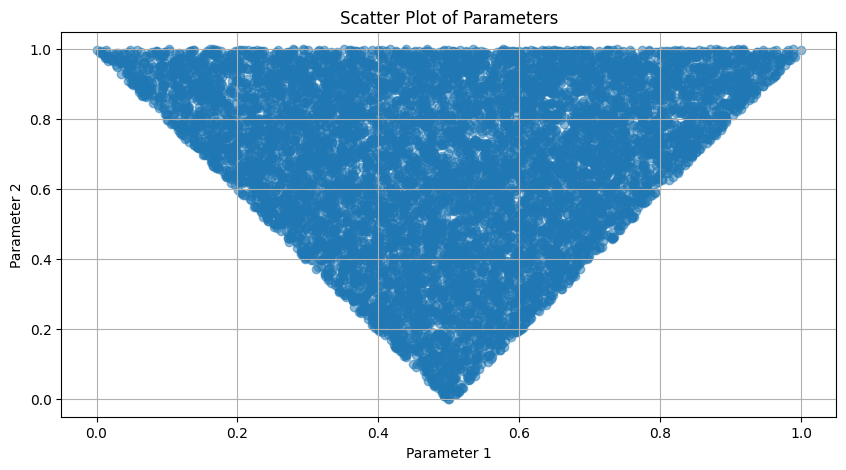

In [14]:
ma2.plot_prior(train_theta_norm)


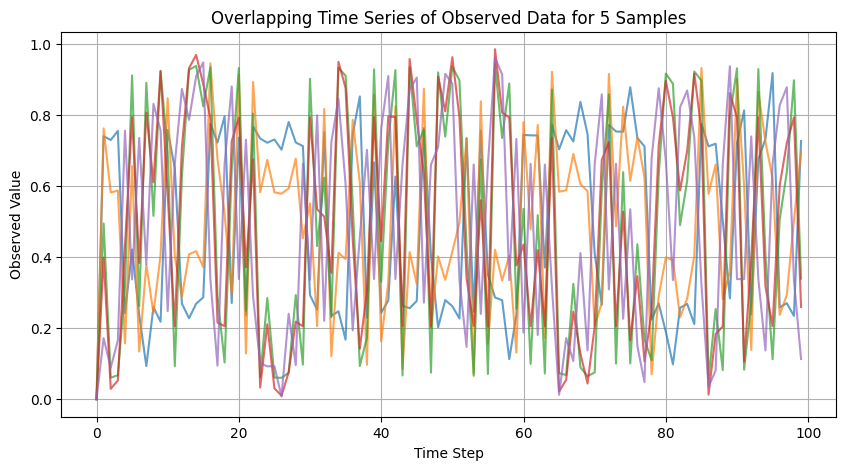

In [15]:
ma2.plot_observation(train_data_norm, 5)

In [16]:
ma2.check_normalizer()


Normalization and denormalization process is consistent for both parameters and observed data.


In [17]:
#print(hello)

In [ ]:

# input_dim = 10  
# latent_dim = 2
# conditional_dim = 5  
# encoder_hidden_dims = [256, 128, 64]
# decoder_hidden_dims = [64, 128, 256]


# network = CVAE(input_dim=input_dim, latent_dim=latent_dim, output_dim=input_dim,
#         conditional_dim=conditional_dim, encoder_hidden_dims=encoder_hidden_dims,
#         decoder_hidden_dims=decoder_hidden_dims)


# optimizer = optim.Adam(network.parameters(), lr=1e-3)


# num_samples = 1000  
# x_dummy = torch.randn(num_samples, input_dim)  
# theta = torch.tensor(x_dummy, dtype=torch.float32)

# c_dummy = torch.randn(num_samples, conditional_dim)
# data = torch.tensor(c_dummy, dtype=torch.float32)

# theta_normalizer = DataNormalizer()
# data_normalizer = DataNormalizer()

# # Fit and transform thetas
# theta_normalizer.fit(theta)
# train_theta_norm = theta_normalizer.transform(theta)

# # Fit and transform data
# data_normalizer.fit(data)
# train_data_norm = data_normalizer.transform(data)

# print(theta.shape, data.shape)

# train_dataset = TensorDataset(train_data_norm, train_theta_norm)
# train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)





# network.train_model(train_loader=train_loader, optimizer=optimizer, epochs=100, 
#                     device=device, theta_normalizer=theta_normalizer, data_normalizer=data_normalizer, forward_model=dummy)

In [ ]:
def simulator(param, seed=42):
    """
    Simulate a given parameter combination using PyTorch tensors.

    Parameters
    ----------
    param : tensor
        Parameters to simulate (\theta).
    n : integer
        Time series length
    """
    torch.manual_seed(seed)
    
    n =  100
    m = len(param)
    g = torch.randn(n)
    gy = torch.randn(n) *  0.3
    y = torch.zeros(n)
    x = torch.zeros(n)
    for t in range(n):
        x[t] += g[t]
        for p in range(min(t, m)):
            x[t] += g[t -  1 - p] * param[p]
        y[t] = x[t] + gy[t]

    return y


def prior(num_samples):
    """
    Sample parameters or thetas from the prior using PyTorch tensors.

    Parameters
    ----------
    n : integer
        Number of random samples to draw or sample.
    """
    n = num_samples
    p = []
    trials =  0
    acc =  0
    while acc < n:
        trials +=  1
        r = torch.rand(2) * torch.tensor([4,  2]) + torch.tensor([-2, -1])
        if r[1] + r[0] >= -1 and r[1] - r[0] >= -1:
            p.append(r)
            acc +=  1
    return torch.stack(p)

def generate_data(num_samples=1000):
    theta = prior(num_samples=num_samples)
    data = torch.stack([simulator(t) for t in theta])
    return theta, data


In [ ]:
theta, data = generate_data(10000)

KeyboardInterrupt: 

In [ ]:
input_dim = 2
latent_dim = 10
conditional_dim = 100
encoder_hidden_dims = [128, 128]
decoder_hidden_dims = [512,512,512]


network = CVAE(input_dim=input_dim, latent_dim=latent_dim, output_dim=input_dim,
        conditional_dim=conditional_dim, encoder_hidden_dims=encoder_hidden_dims,
        decoder_hidden_dims=decoder_hidden_dims)


optimizer = optim.AdamW(network.parameters(), lr=1e-3)


theta_normalizer = DataNormalizer()
data_normalizer = DataNormalizer()

# Fit and transform thetas
theta_normalizer.fit(theta)
train_theta_norm = theta_normalizer.transform(theta)

# Fit and transform data
data_normalizer.fit(data)
train_data_norm = data_normalizer.transform(data)

print(theta.shape, data.shape)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

network.train_model(train_loader=train_loader, optimizer=optimizer, epochs=10, 
                    device=device, theta_normalizer=theta_normalizer,
                      data_normalizer=data_normalizer, forward_model= simulator)

torch.Size([10000, 2]) torch.Size([10000, 100])
Using CPU


In [ ]:

true_param = torch.tensor([0.6,0.2])
observed_data = simulator(true_param)
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)

torch.Size([10000, 10]) torch.Size([10000, 100])


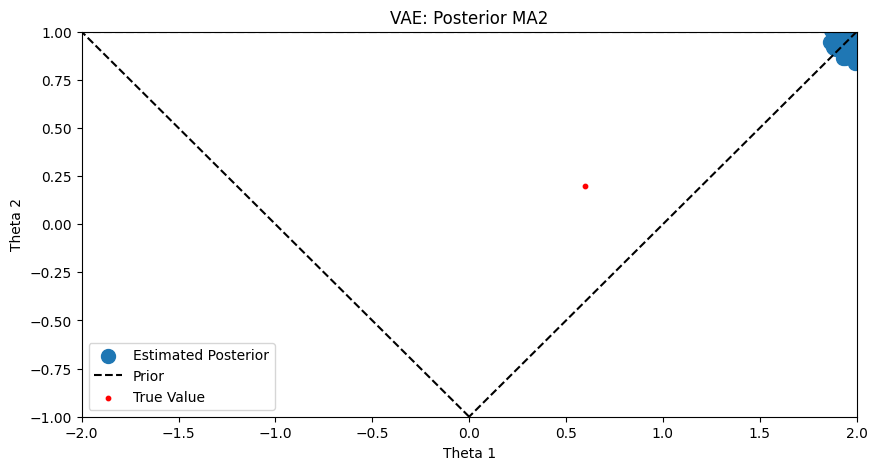

In [ ]:
scatter_plot_ma2(post)

In [ ]:
prior, simulator, posterior

NameError: name 'posterior' is not defined